# Assignment 4: Build a Supervised Autoencoder.

### Name: [Michael Dixon]

### Due Date: Thursday 5/2/2024 11:59PM


PCA and the standard autoencoder are unsupervised dimensionality reduction methods, and their learned features are not discriminative. If you build a classifier upon the low-dimenional features extracted by PCA and autoencoder, you will find the classification accuracy very poor.

Linear discriminant analysis (LDA) is a traditionally supervised dimensionality reduction method for learning low-dimensional features which are highly discriminative. Likewise, can we extend autoencoder to supervised learning?



**You are required to build and train a supervised autoencoder look like the following.** You are required to add other layers properly to alleviate overfitting.

<img src="ae.PNG"/>


## 0. You will do the following:

1. Build a standard dense autoencoder, visualize the low-dim features and the reconstructions, and evaluate whether the learned low-dim features are discriminative.

2. Repeat the above process by training a supervised autoencoder.


## 1. Data preparation

### 1.1. Load data


In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import models
from IPython.display import SVG
from keras.utils import model_to_dot, plot_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import numpy as np





(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28*28).astype('float32') / 255.
x_test = x_test.reshape(10000, 28*28).astype('float32') / 255.

print('Shape of x_train: ' + str(x_train.shape)) 
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (60000, 784)
Shape of x_test: (10000, 784)
Shape of y_train: (60000,)
Shape of y_test: (10000,)


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transforms such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
def to_one_hot(y, num_class=10):
    results = np.zeros((len(y), num_class))
    for i, label in enumerate(y):
        results[i, label] = 1.
    return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (60000, 10)
Shape of y_test_vec: (10000, 10)
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 60K training samples to 2 sets:
* a training set containing 10K samples;
* a validation set containing 50K samples. (You can use only 10K to save time.)


In [3]:
rand_indices = np.random.permutation(60000)
train_indices = rand_indices[0:10000]
valid_indices = rand_indices[10000:60000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))


Shape of x_tr: (10000, 784)
Shape of y_tr: (10000, 10)
Shape of x_val: (50000, 784)
Shape of y_val: (50000, 10)


## 2. Build an unsupervised  autoencoder and tune its hyper-parameters

1. Build a dense autoencoder model
2. Your encoder should contain 3 dense layers and 1 bottleneck layer with 2 as  output size. 
3. Your decoder should contain 4 dense layers with 784 as output size.
4. You can choose different number of hidden units in dense layers.
5. Do not add other layers (no activation layers), you may add them in later sections.
6. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
    
7. Try to achieve a validation loss as low as possible.
8. Evaluate the model on the test set.
9. Visualize the low-dim features and reconstructions.


### 2.1. Build the model (20 points)

In [4]:
input_img = Input(shape=(784,), name='input_img')


encode1 = Dense(128, activation='relu')(input_img)
encode2 = Dense(64, activation='relu')(encode1)
encode3 = Dense(32, activation='relu')(encode2)
bottleneck = Dense(2, activation='relu')(encode3)

decode1 = Dense(32, activation='relu')(bottleneck)
decode2 = Dense(64, activation='relu')(decode1)
decode3 = Dense(128, activation='relu')(decode2)
decode4 = Dense(784, activation='sigmoid')(decode3)  


ae = models.Model(input_img, decode4)


ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
 dense_4 (Dense)             (None, 32)                96        
                                                                 
 dense_5 (Dense)             (None, 64)                2112  

In [5]:
# print the network structure to a PDF file
SVG(model_to_dot(ae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=ae, show_shapes=False,
    to_file='unsupervised_ae.pdf'
)

# you can find the file "unsupervised_ae.pdf" in the current directory.

### 2.2. Train the model and tune the hyper-parameters (5 points)

In [6]:
learning_rate = 1E-4 # to be tuned!

#Learning rate tuned, but chose to stay around 1E-3/1E-4 as it maximizes accuracy in parts 3-4

ae.compile(loss='mean_squared_error', optimizer=optimizers.RMSprop(learning_rate = learning_rate))

In [7]:
history = ae.fit(x_tr, x_tr, 
                 batch_size=128, 
                 epochs=100, 
                 validation_data=(x_val, x_val))

Epoch 1/100


2024-04-29 16:59:52.832055: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


79/79 [==============================] - 1s 8ms/step - loss: 0.1838 - val_loss: 0.1140
Epoch 2/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0852 - val_loss: 0.0725
Epoch 3/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0702 - val_loss: 0.0688
Epoch 4/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0677 - val_loss: 0.0671
Epoch 5/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0663 - val_loss: 0.0660
Epoch 6/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0653 - val_loss: 0.0652
Epoch 7/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0645 - val_loss: 0.0644
Epoch 8/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0637 - val_loss: 0.0634
Epoch 9/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0626 - val_loss: 0.0623
Epoch 10/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0612 - val_loss: 0.0607
Epoch 11/100
79/79 [=

79/79 [==============================] - 1s 8ms/step - loss: 0.0498 - val_loss: 0.0508
Epoch 84/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0497 - val_loss: 0.0506
Epoch 85/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0497 - val_loss: 0.0505
Epoch 86/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0497 - val_loss: 0.0506
Epoch 87/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0496 - val_loss: 0.0505
Epoch 88/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0496 - val_loss: 0.0507
Epoch 89/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0495 - val_loss: 0.0506
Epoch 90/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0495 - val_loss: 0.0505
Epoch 91/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0495 - val_loss: 0.0505
Epoch 92/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0494 - val_loss: 0.0504
Epoch 93/100


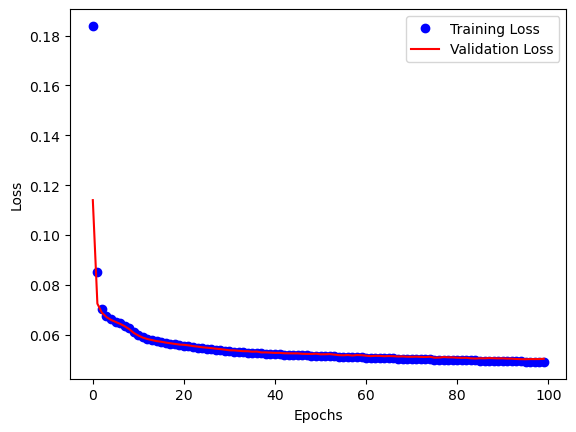

In [8]:
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.3. Visualize the reconstructed test images (5 points)

313/313 [==============================] - 0s 813us/step


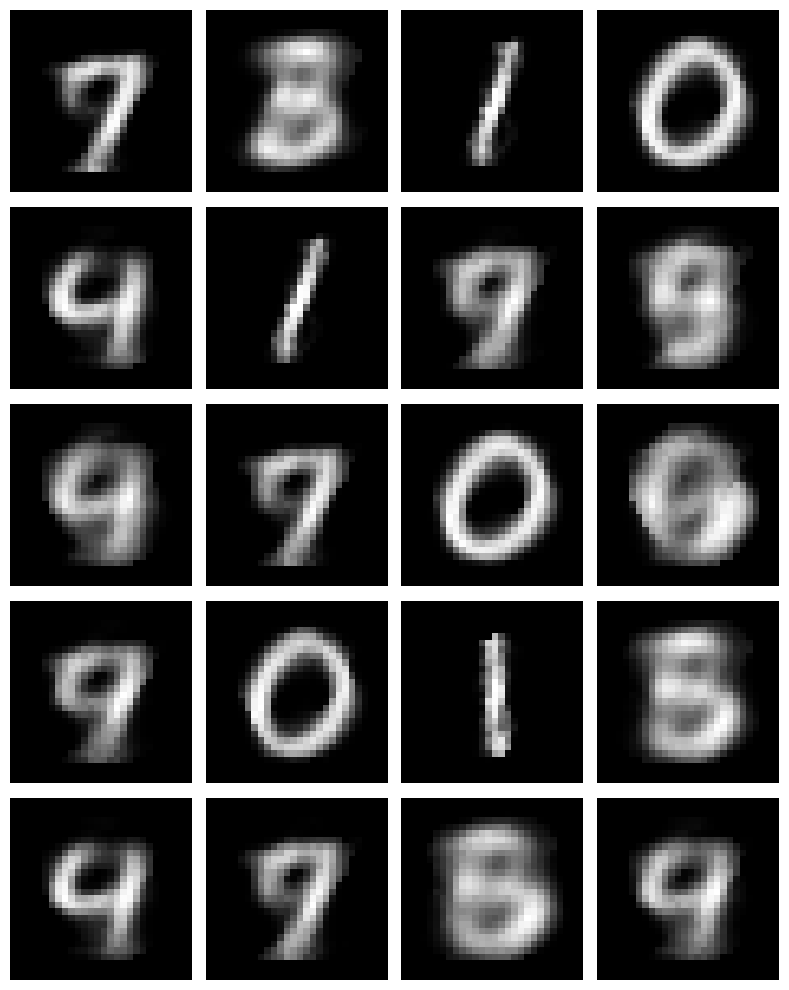

In [9]:
ae_output = ae.predict(x_test).reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = ae_output
fname = 'reconstruct_ae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 2.4. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [10]:
loss = ae.evaluate(x_test, x_test)
print('loss = ' + str(loss))

313/313 [==============================] - 0s 650us/step - loss: 0.0501
loss = 0.050061799585819244


### 2.5. Visualize the low-dimensional features

In [11]:
# build the encoder network
ae_encoder = models.Model(input_img, bottleneck)
ae_encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 110,882
Trainable params: 110,882
Non-trainable params: 0
_________________________________________________________________


In [12]:
# extract low-dimensional features from the test data
encoded_test = ae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

313/313 [==============================] - 0s 406us/step
Shape of encoded_test: (10000, 2)


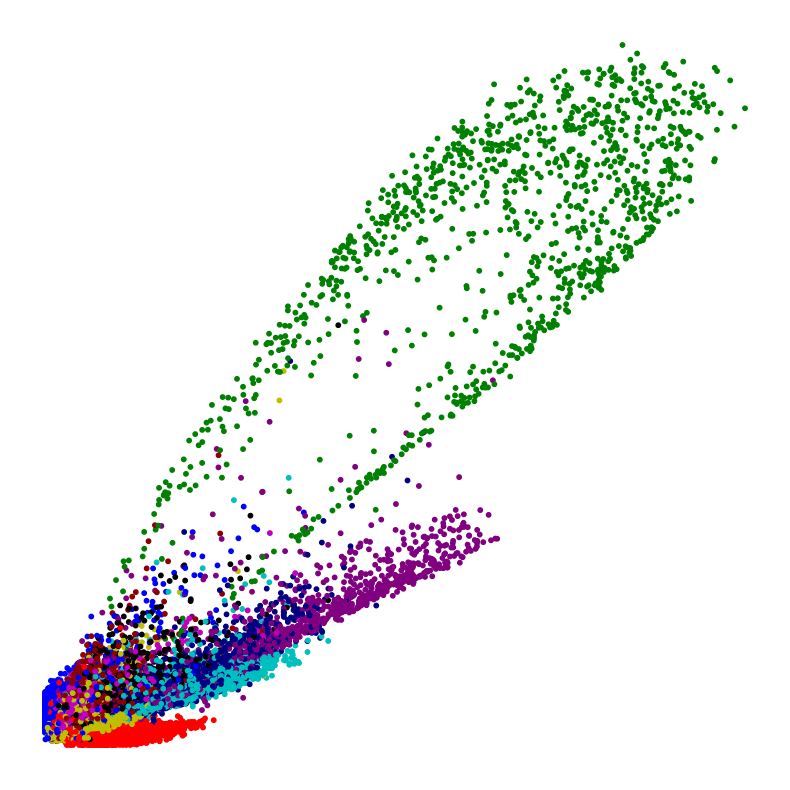

In [13]:
colors = np.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'ae_code.pdf'
plt.savefig(fname)

#### Remark:

Judging from the visualization, the low-dim features seems not discriminative, as 2D features from different classes are mixed. Let quantitatively find out whether they are discriminative.

## 3. Are the learned low-dim features discriminative? (10 points)

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the test set.

In [14]:
# extract the 2D features from the training, validation, and test samples
f_tr = ae_encoder.predict(x_tr)
f_val = ae_encoder.predict(x_val)
f_te = ae_encoder.predict(x_test)

print('Shape of f_tr: ' + str(f_tr.shape))
print('Shape of f_te: ' + str(f_te.shape))

313/313 [==============================] - 0s 356us/step
Shape of f_tr: (10000, 2)
Shape of f_te: (10000, 2)


In [15]:
input_feat = Input(shape=(2,))

hidden1 = Dense(128, activation='relu')(input_feat)
hidden2 = Dense(128, activation='relu')(hidden1)
output = Dense(10, activation='softmax')(hidden2)

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_8 (Dense)             (None, 128)               384       
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 10)                1290      
                                                                 
Total params: 18,186
Trainable params: 18,186
Non-trainable params: 0
_________________________________________________________________


In [16]:
classifier.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(learning_rate = learning_rate),
                   metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Epoch 1/30
313/313 [==============================] - 1s 2ms/step - loss: 2.0903 - acc: 0.3075 - val_loss: 1.6087 - val_acc: 0.3933
Epoch 2/30
313/313 [==============================] - 1s 2ms/step - loss: 1.5475 - acc: 0.4353 - val_loss: 1.5438 - val_acc: 0.4310
Epoch 3/30
313/313 [==============================] - 1s 2ms/step - loss: 1.4794 - acc: 0.4633 - val_loss: 1.4893 - val_acc: 0.4327
Epoch 4/30
313/313 [==============================] - 1s 2ms/step - loss: 1.4340 - acc: 0.4757 - val_loss: 1.4539 - val_acc: 0.4654
Epoch 5/30
313/313 [==============================] - 1s 2ms/step - loss: 1.3977 - acc: 0.4879 - val_loss: 1.3942 - val_acc: 0.4814
Epoch 6/30
313/313 [==============================] - 1s 2ms/step - loss: 1.3675 - acc: 0.4950 - val_loss: 1.3801 - val_acc: 0.4847
Epoch 7/30
313/313 [==============================] - 1s 2ms/step - loss: 1.3417 - acc: 0.5008 - val_loss: 1.3600 - val_acc: 0.4854
Epoch 8/30
313/313 [==============================] - 1s 2ms/step - loss: 1.

### Conclusion

Using the 2D features, the validation accuracy is 60~70%. Recall that using the original data, the accuracy is about 97%. Obviously, the 2D features are not very discriminative.

We are going to build a supervised autoencode model for learning low-dimensional discriminative features.

## 4. Build a supervised autoencoder model


**You are required to build and train a supervised autoencoder look like the following.** (Not necessary the same. You can use convolutional layers as well.) You are required to add other layers properly to alleviate overfitting.

<img src="ae.PNG"/>


### 4.1. Build the network (30 points)

In [17]:
#ChatGPT was consulted to modify the structure, specifically in adding dropout for regularization and prevent  
#Overfitting. Also in how to change the names so when the network is printed, it appears exactly as the example. 


input_img = Input(shape=(784,), name='input_img')


encode1 = Dense(128, activation='relu', name='encode1')(input_img)
encode2 = Dense(64, activation='relu', name='encode2')(encode1)
encode3 = Dense(32, activation='relu', name='encode3')(encode2)
bottleneck = Dense(2, activation='relu', name='bottleneck')(encode3)


decode1 = Dense(32, activation='relu', name='decode1')(bottleneck)
decode2 = Dense(64, activation='relu', name='decode2')(decode1)
decode3 = Dense(128, activation='relu', name='decode3')(decode2)
decode4 = Dense(784, activation='sigmoid', name='decode4')(decode3)


classifier1 = Dense(32, activation='relu', name='classifier1')(bottleneck)
classifier2 = Dropout(0.5, name='classifier2')(classifier1)  
classifier3 = Dense(10, activation='softmax', name='classifier3')(classifier2)  

In [18]:
# connect the input and the two outputs
sae = models.Model(input_img, [decode4, classifier3])

sae.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 784)]        0           []                               
                                                                                                  
 encode1 (Dense)                (None, 128)          100480      ['input_img[0][0]']              
                                                                                                  
 encode2 (Dense)                (None, 64)           8256        ['encode1[0][0]']                
                                                                                                  
 encode3 (Dense)                (None, 32)           2080        ['encode2[0][0]']                
                                                                                            

In [19]:
# print the network structure to a PDF file

SVG(model_to_dot(sae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=sae, show_shapes=False,
    to_file='supervised_ae.pdf'
)

# you can find the file "supervised_ae.pdf" in the current directory.

### 4.2. Train the new model and tune the hyper-parameters

The new model has multiple output. Thus we specify **multiple** loss functions and their weights. 

In [20]:
sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=[1, 0.5], # to be tuned
            optimizer=optimizers.RMSprop(learning_rate = 1E-3))

history = sae.fit(x_tr, [x_tr, y_tr], 
                  batch_size=32, 
                  epochs=100, 
                  validation_data=(x_val, [x_val, y_val]))

Epoch 1/100
313/313 [==============================] - 2s 5ms/step - loss: 1.0479 - decode4_loss: 0.0738 - classifier3_loss: 1.9480 - val_loss: 0.8272 - val_decode4_loss: 0.0596 - val_classifier3_loss: 1.5352
Epoch 2/100
313/313 [==============================] - 1s 5ms/step - loss: 0.7995 - decode4_loss: 0.0586 - classifier3_loss: 1.4817 - val_loss: 0.6725 - val_decode4_loss: 0.0583 - val_classifier3_loss: 1.2284
Epoch 3/100
313/313 [==============================] - 1s 5ms/step - loss: 0.6739 - decode4_loss: 0.0575 - classifier3_loss: 1.2329 - val_loss: 0.5897 - val_decode4_loss: 0.0577 - val_classifier3_loss: 1.0640
Epoch 4/100
313/313 [==============================] - 1s 5ms/step - loss: 0.6039 - decode4_loss: 0.0568 - classifier3_loss: 1.0940 - val_loss: 0.5283 - val_decode4_loss: 0.0580 - val_classifier3_loss: 0.9406
Epoch 5/100
313/313 [==============================] - 1s 5ms/step - loss: 0.5646 - decode4_loss: 0.0565 - classifier3_loss: 1.0161 - val_loss: 0.5123 - val_decode4

313/313 [==============================] - 2s 5ms/step - loss: 0.1843 - decode4_loss: 0.0501 - classifier3_loss: 0.2684 - val_loss: 0.9759 - val_decode4_loss: 0.0509 - val_classifier3_loss: 1.8499
Epoch 41/100
313/313 [==============================] - 1s 5ms/step - loss: 0.1687 - decode4_loss: 0.0502 - classifier3_loss: 0.2370 - val_loss: 1.0078 - val_decode4_loss: 0.0512 - val_classifier3_loss: 1.9132
Epoch 42/100
313/313 [==============================] - 1s 5ms/step - loss: 0.1753 - decode4_loss: 0.0500 - classifier3_loss: 0.2506 - val_loss: 0.9910 - val_decode4_loss: 0.0508 - val_classifier3_loss: 1.8804
Epoch 43/100
313/313 [==============================] - 1s 5ms/step - loss: 0.1736 - decode4_loss: 0.0501 - classifier3_loss: 0.2471 - val_loss: 1.0275 - val_decode4_loss: 0.0507 - val_classifier3_loss: 1.9536
Epoch 44/100
313/313 [==============================] - 1s 5ms/step - loss: 0.1686 - decode4_loss: 0.0500 - classifier3_loss: 0.2372 - val_loss: 1.1212 - val_decode4_loss: 0

313/313 [==============================] - 2s 5ms/step - loss: 0.1876 - decode4_loss: 0.0492 - classifier3_loss: 0.2768 - val_loss: 4.2788 - val_decode4_loss: 0.0498 - val_classifier3_loss: 8.4579
Epoch 80/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1939 - decode4_loss: 0.0494 - classifier3_loss: 0.2890 - val_loss: 3.6380 - val_decode4_loss: 0.0502 - val_classifier3_loss: 7.1757
Epoch 81/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1848 - decode4_loss: 0.0492 - classifier3_loss: 0.2712 - val_loss: 4.1851 - val_decode4_loss: 0.0499 - val_classifier3_loss: 8.2703
Epoch 82/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1720 - decode4_loss: 0.0491 - classifier3_loss: 0.2458 - val_loss: 3.8633 - val_decode4_loss: 0.0497 - val_classifier3_loss: 7.6273
Epoch 83/100
313/313 [==============================] - 2s 5ms/step - loss: 0.2371 - decode4_loss: 0.0491 - classifier3_loss: 0.3759 - val_loss: 4.2864 - val_decode4_loss: 0

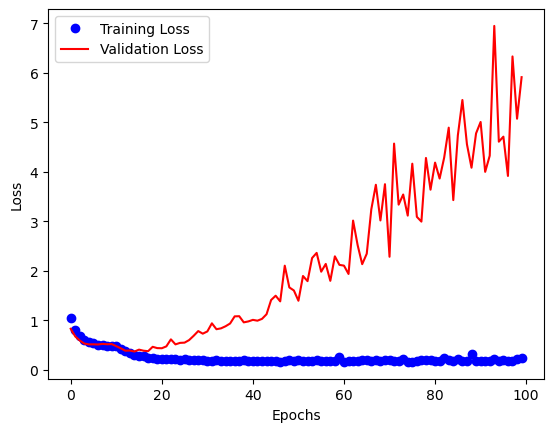

In [21]:
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Question  (10 points)

Do you think overfitting is happening? If yes, what can you do? Please make necessary changes to the supervised autoencoder network structure.

You can use the new model without overfitting for the following sections.

Yes, there is overfitting right now, as we see with my validation loss being magnitudes larger than my training loss at just about every single epoch. Below we will modify the above structure to reduce training loss:

In [22]:
#ChatGPT was consulted again to use batch normalization to improve model performance and regularize it

input_img = Input(shape=(784,), name='input_img')


encode1 = Dense(128, activation='relu')(input_img)
encode1_bn = BatchNormalization()(encode1)
encode2 = Dense(64, activation='relu')(encode1_bn)
encode2_bn = BatchNormalization()(encode2)
encode3 = Dense(32, activation='relu')(encode2_bn)
encode3_bn = BatchNormalization()(encode3)
bottleneck = Dense(2, activation='relu')(encode3_bn)


decode1 = Dense(32, activation='relu')(bottleneck)
decode1_bn = BatchNormalization()(decode1)
decode2 = Dense(64, activation='relu')(decode1_bn)
decode2_bn = BatchNormalization()(decode2)
decode3 = Dense(128, activation='relu')(decode2_bn)
decode3_bn = BatchNormalization()(decode3)
decoded_output = Dense(784, activation='sigmoid', name='decoded_output')(decode3_bn)  


classifier1 = Dense(32, activation='relu')(bottleneck)
classifier1_bn = BatchNormalization()(classifier1)
classifier1_do = Dropout(0.5)(classifier1_bn)
classified_output = Dense(10, activation='softmax', name='classified_output')(classifier1_do)  


sae = Model(input_img, [decoded_output, classified_output])

sae.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 784)]        0           []                               
                                                                                                  
 dense_11 (Dense)               (None, 128)          100480      ['input_img[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 128)         512         ['dense_11[0][0]']               
 alization)                                                                                       
                                                                                                  
 dense_12 (Dense)               (None, 64)           8256        ['batch_normalization[0][0]

In [23]:
# Compile the model with names
sae.compile(
    optimizer='adam',
    loss={'decoded_output': 'mean_squared_error', 'classified_output': 'categorical_crossentropy'},
    loss_weights={'decoded_output': 1, 'classified_output': 0.5},
    metrics={'decoded_output': 'mse', 'classified_output': 'accuracy'}
)


# Fit the model
history = sae.fit(x_tr, {'decoded_output': x_tr, 'classified_output': y_tr}, 
                  batch_size=32, 
                  epochs=100, 
                  validation_data=(x_val, {'decoded_output': x_val, 'classified_output': y_val}))



Epoch 1/100
313/313 [==============================] - 2s 6ms/step - loss: 1.0548 - decoded_output_loss: 0.1053 - classified_output_loss: 1.8991 - decoded_output_mse: 0.1053 - classified_output_accuracy: 0.2936 - val_loss: 0.7941 - val_decoded_output_loss: 0.0625 - val_classified_output_loss: 1.4632 - val_decoded_output_mse: 0.0625 - val_classified_output_accuracy: 0.4051
Epoch 2/100
313/313 [==============================] - 2s 5ms/step - loss: 0.7681 - decoded_output_loss: 0.0604 - classified_output_loss: 1.4155 - decoded_output_mse: 0.0604 - classified_output_accuracy: 0.4257 - val_loss: 0.6534 - val_decoded_output_loss: 0.0599 - val_classified_output_loss: 1.1871 - val_decoded_output_mse: 0.0599 - val_classified_output_accuracy: 0.5087
Epoch 3/100
313/313 [==============================] - 2s 5ms/step - loss: 0.6769 - decoded_output_loss: 0.0598 - classified_output_loss: 1.2342 - decoded_output_mse: 0.0598 - classified_output_accuracy: 0.4909 - val_loss: 0.5985 - val_decoded_output

Epoch 23/100
313/313 [==============================] - 2s 6ms/step - loss: 0.2661 - decoded_output_loss: 0.0556 - classified_output_loss: 0.4211 - decoded_output_mse: 0.0556 - classified_output_accuracy: 0.8304 - val_loss: 0.2926 - val_decoded_output_loss: 0.0551 - val_classified_output_loss: 0.4749 - val_decoded_output_mse: 0.0551 - val_classified_output_accuracy: 0.8337
Epoch 24/100
313/313 [==============================] - 2s 6ms/step - loss: 0.2741 - decoded_output_loss: 0.0556 - classified_output_loss: 0.4371 - decoded_output_mse: 0.0556 - classified_output_accuracy: 0.8327 - val_loss: 0.2973 - val_decoded_output_loss: 0.0553 - val_classified_output_loss: 0.4839 - val_decoded_output_mse: 0.0553 - val_classified_output_accuracy: 0.8381
Epoch 25/100
313/313 [==============================] - 2s 6ms/step - loss: 0.2532 - decoded_output_loss: 0.0554 - classified_output_loss: 0.3954 - decoded_output_mse: 0.0554 - classified_output_accuracy: 0.8409 - val_loss: 0.2866 - val_decoded_out

Epoch 45/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1680 - decoded_output_loss: 0.0533 - classified_output_loss: 0.2294 - decoded_output_mse: 0.0533 - classified_output_accuracy: 0.9399 - val_loss: 0.2367 - val_decoded_output_loss: 0.0527 - val_classified_output_loss: 0.3680 - val_decoded_output_mse: 0.0527 - val_classified_output_accuracy: 0.9398
Epoch 46/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1734 - decoded_output_loss: 0.0532 - classified_output_loss: 0.2404 - decoded_output_mse: 0.0532 - classified_output_accuracy: 0.9371 - val_loss: 0.2293 - val_decoded_output_loss: 0.0527 - val_classified_output_loss: 0.3532 - val_decoded_output_mse: 0.0527 - val_classified_output_accuracy: 0.9470
Epoch 47/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1649 - decoded_output_loss: 0.0534 - classified_output_loss: 0.2229 - decoded_output_mse: 0.0534 - classified_output_accuracy: 0.9370 - val_loss: 0.2342 - val_decoded_out

Epoch 67/100
313/313 [==============================] - 2s 6ms/step - loss: 0.1304 - decoded_output_loss: 0.0531 - classified_output_loss: 0.1547 - decoded_output_mse: 0.0531 - classified_output_accuracy: 0.9603 - val_loss: 0.2492 - val_decoded_output_loss: 0.0527 - val_classified_output_loss: 0.3931 - val_decoded_output_mse: 0.0527 - val_classified_output_accuracy: 0.9494
Epoch 68/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1318 - decoded_output_loss: 0.0532 - classified_output_loss: 0.1573 - decoded_output_mse: 0.0532 - classified_output_accuracy: 0.9569 - val_loss: 0.2747 - val_decoded_output_loss: 0.0524 - val_classified_output_loss: 0.4446 - val_decoded_output_mse: 0.0524 - val_classified_output_accuracy: 0.9466
Epoch 69/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1284 - decoded_output_loss: 0.0527 - classified_output_loss: 0.1514 - decoded_output_mse: 0.0527 - classified_output_accuracy: 0.9598 - val_loss: 0.2533 - val_decoded_out

Epoch 89/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1178 - decoded_output_loss: 0.0527 - classified_output_loss: 0.1303 - decoded_output_mse: 0.0527 - classified_output_accuracy: 0.9668 - val_loss: 0.3142 - val_decoded_output_loss: 0.0563 - val_classified_output_loss: 0.5159 - val_decoded_output_mse: 0.0563 - val_classified_output_accuracy: 0.9452
Epoch 90/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1141 - decoded_output_loss: 0.0527 - classified_output_loss: 0.1227 - decoded_output_mse: 0.0527 - classified_output_accuracy: 0.9669 - val_loss: 0.2768 - val_decoded_output_loss: 0.0517 - val_classified_output_loss: 0.4500 - val_decoded_output_mse: 0.0517 - val_classified_output_accuracy: 0.9504
Epoch 91/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1075 - decoded_output_loss: 0.0526 - classified_output_loss: 0.1098 - decoded_output_mse: 0.0526 - classified_output_accuracy: 0.9713 - val_loss: 0.2861 - val_decoded_out

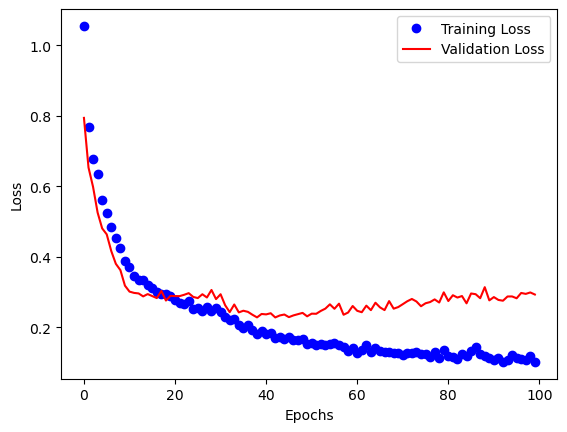

In [24]:
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Here, while some overfitting still occurs, it is not nearly as bad as before as our validation loss has dramatically reduced. This means we kept our training accuracy strong, without sacrificing validation. 

### 4.3. Visualize the reconstructed test images

313/313 [==============================] - 0s 677us/step


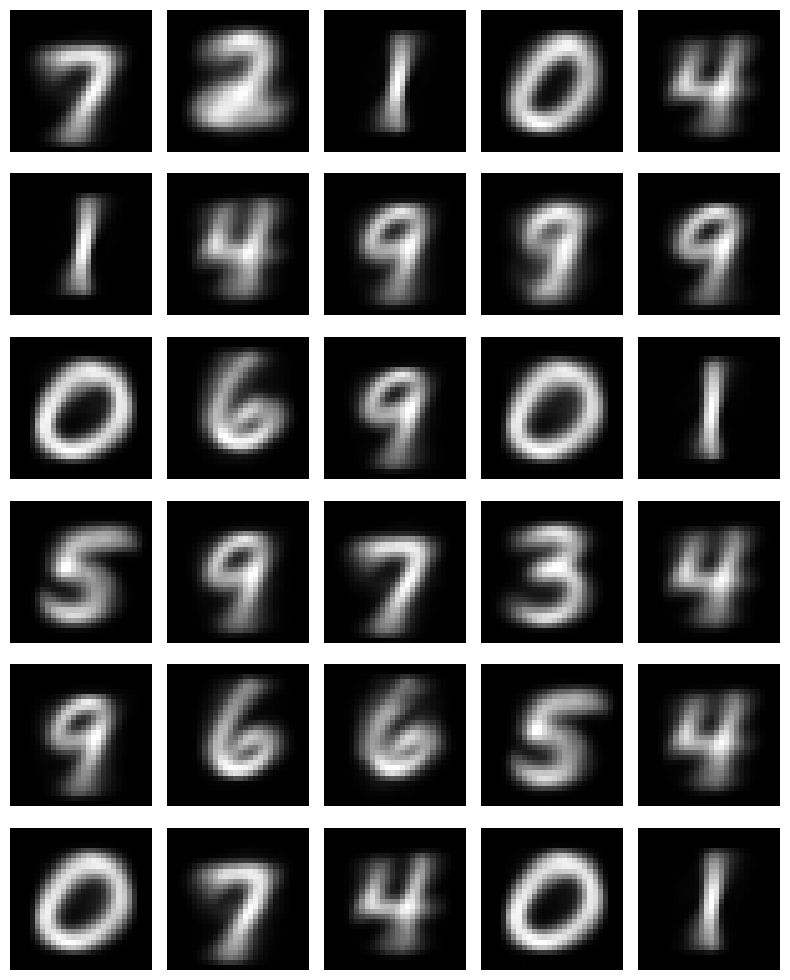

In [25]:
sae_output = sae.predict(x_test)[0].reshape((10000, 28, 28))

ROW = 6
COLUMN = 5

x = sae_output
fname = 'reconstruct_sae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 4.4. Visualize the low-dimensional features



In [26]:
# build the encoder model
sae_encoder = models.Model(input_img, bottleneck)
sae_encoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 784)]             0         
                                                                 
 dense_11 (Dense)            (None, 128)               100480    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_13 (Dense)            (None, 32)                2080

313/313 [==============================] - 0s 419us/step
Shape of encoded_test: (10000, 2)


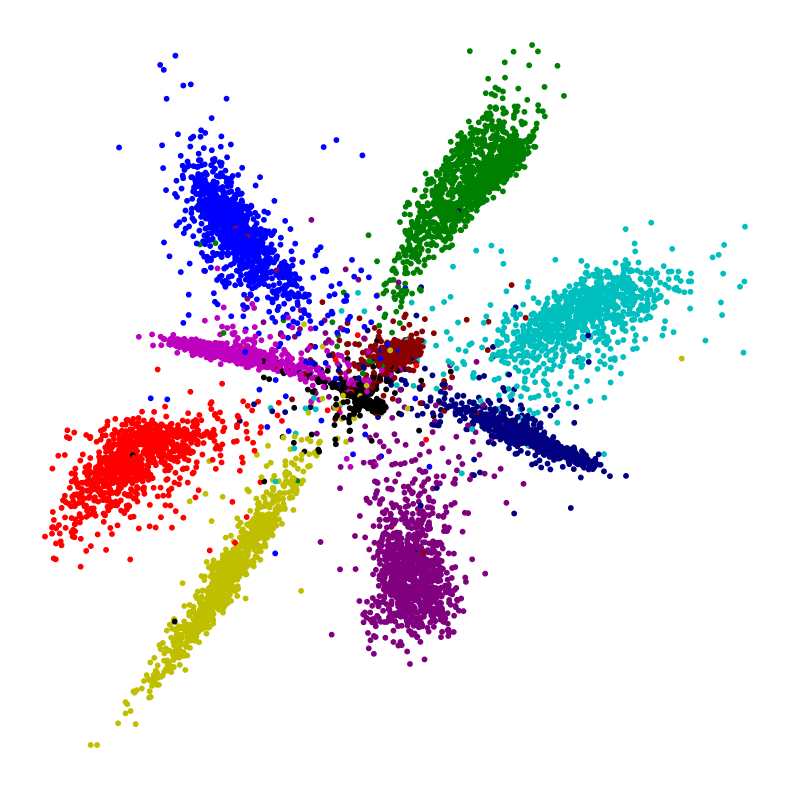

In [27]:
# extract test features
encoded_test = sae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

colors = np.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'sae_code.pdf'
plt.savefig(fname)

### 4.5. Are the learned low-dim features discriminative? (10 points)

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the validation and test set.



In [28]:
# extract 2D features from the training, validation, and test samples
f_tr = sae_encoder.predict(x_tr)
f_val = sae_encoder.predict(x_val)
f_te = sae_encoder.predict(x_test)

313/313 [==============================] - 0s 369us/step


In [31]:
input_feat = Input(shape=(2,), name='input_feat')

x = Dense(64, activation='relu')(input_feat)
x = Dropout(0.5)(x) 
x = Dense(32, activation='relu')(x)
output = Dense(10, activation='softmax')(x)



classifier = Model(input_feat, output)
classifier.summary()


classifier.compile(loss='categorical_crossentropy',
                   optimizer = optimizers.RMSprop(learning_rate = learning_rate),
                   metrics=['accuracy'])


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_feat (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_25 (Dense)            (None, 64)                192       
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dense_27 (Dense)            (None, 10)                330       
                                                                 
Total params: 2,602
Trainable params: 2,602
Non-trainable params: 0
_________________________________________________________________


In [32]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate = 1E-3),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Epoch 1/30
313/313 [==============================] - 1s 2ms/step - loss: 1.8586 - acc: 0.2755 - val_loss: 1.3027 - val_acc: 0.5555
Epoch 2/30
313/313 [==============================] - 1s 2ms/step - loss: 1.1509 - acc: 0.5214 - val_loss: 0.9686 - val_acc: 0.7284
Epoch 3/30
313/313 [==============================] - 1s 2ms/step - loss: 0.8426 - acc: 0.6754 - val_loss: 0.7711 - val_acc: 0.8613
Epoch 4/30
313/313 [==============================] - 1s 2ms/step - loss: 0.6348 - acc: 0.7667 - val_loss: 0.6501 - val_acc: 0.8570
Epoch 5/30
313/313 [==============================] - 1s 2ms/step - loss: 0.4838 - acc: 0.8280 - val_loss: 0.5702 - val_acc: 0.9027
Epoch 6/30
313/313 [==============================] - 1s 2ms/step - loss: 0.3793 - acc: 0.8702 - val_loss: 0.5335 - val_acc: 0.9027
Epoch 7/30
313/313 [==============================] - 1s 2ms/step - loss: 0.3056 - acc: 0.9034 - val_loss: 0.4896 - val_acc: 0.9269
Epoch 8/30
313/313 [==============================] - 1s 2ms/step - loss: 0.

#### Remark: (10 points)

The validation accuracy must be above 90%. It means the low-dim features learned by the supervised autoencoder are very effective.

In [33]:
# evaluate your model on the never-seen-before test data
# write your code here:
...

test_loss, test_acc = classifier.evaluate(f_te, y_test_vec)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")


313/313 [==============================] - 0s 305us/step - loss: 0.7066 - acc: 0.9490
Test Loss: 0.7066120505332947, Test Accuracy: 0.9490000009536743


As we can see from the training above, our validation accuracy was 94.77%, which is excellent. Moreover our test accuracy is almost equivalent, at 94.90%. This means our autencoder learns the features and classifies extremely well. 